In [4]:
from os import listdir
from os.path import isfile, join

from pathlib import Path

import ast

import networkx as nx

from collections import defaultdict

import matplotlib

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np

from math import ceil

from algo.helpers import input_graph, input_generated_graph_and_processors_from_file

%matplotlib inline

In [ ]:
graph_types: list[str] = [
    'layered',
    'random',
    'triangle',
]

path_greed: str = './results/greed/weighted/{graph_type}/{{graph_name}}'
path_greed_mk: str = './results/MK_greed_greed_weighted/weighted/{graph_type}/{{graph_name}}'
path_mk_geq_cr: str = './results/MK_greed_greed_with_geq_cr/weighted/{graph_type}/{{graph_name}}'
path_simple: str = './results/simple_part/weighted/{graph_type}/{{graph_name}}'

In [7]:
path_data_time: list[tuple[str, dict, dict]] = [
    (path_greed, greed_data := dict(), greed_time := dict()),
    (path_greed_mk, greed_mk_data := dict(), greed_mk_time := dict()),
    # (path_mk_geq_cr, data_mk_geq_cr := dict(), time_mk_geq_cr := dict()),
    (path_simple, simple_data := dict(), simple_time := dict()),
]

cr_set = set()
for path, data, times in path_data_time:
    for graph_type in graph_types:
        # время
        if graph_type not in times:
            times[graph_type] = dict()
        files = list(filter(lambda x: x.endswith('.time'), listdir(path.format(graph_type=graph_type).removesuffix('/{graph_name}'))))
        for graph_name in files:
            
            times[graph_type][graph_name] = defaultdict(dict)
            with open(path.format(graph_type=graph_type).format(graph_name=graph_name), 'r') as file:
                for line in file.readlines():
                    line = line.strip()
                    try:
                        # triadag20_5.txt 3_2x4.txt 0.3 210 1740493448.3341758 6804.933112382889 
                        g_name, pg_name, cr_lim, partition_ken, start_time, overall_time = line.split()
                        if g_name.replace('.txt', '.time') != graph_name.split('/')[-1]:
                            continue
                        cr_lim, partition_ken, start_time, overall_time = float(cr_lim), int(partition_ken) if partition_ken != 'None' else None, float(start_time), float(overall_time)
                    except Exception as e:
                        print(cr_lim, partition_ken, start_time, overall_time)
                        print(e)
                        print(line)
                        print(path)
                        continue

                    pg_name = pg_name.removesuffix('.txt')
                    pg_name = '_'.join(list(map(str, sorted(list(map(int, pg_name.split('x')[0].split('_'))), reverse=True)))) + 'x' + pg_name.split('x')[1]
                    
                    cr_set.add(cr_lim)
                    times[graph_type][graph_name][pg_name][cr_lim] = float(overall_time)
        # ЦФы
        if graph_type not in data:
            data[graph_type] = dict()
        print(path.format(graph_type=graph_type).removesuffix('/{graph_name}'))
        files = list(filter(lambda x: x.endswith('.txt'), listdir(path.format(graph_type=graph_type).removesuffix('/{graph_name}'))))
        for graph_name in files:
            data[graph_type][graph_name] = defaultdict(dict)
            with open(path.format(graph_type=graph_type).format(graph_name=graph_name), 'r') as file:
                for line in file.readlines():
                    line = line.strip()
                    try:
                        g_name, pg_name, cr, cr_lim, f_val, *_ = line.split()
                        if g_name != graph_name.split('/')[-1]:
                            continue
                        cr, cr_lim, f_val = float(cr) if cr != 'None' else None, float(cr_lim), float(f_val)
                    except Exception as e:
                        print(cr, cr_lim, f_val)
                        print(e)
                        print(line)
                        print(path)
                        continue

                    pg_name = pg_name.removesuffix('.txt')
                    pg_name = '_'.join(list(map(str, sorted(list(map(int, pg_name.split('x')[0].split('_'))), reverse=True)))) + 'x' + pg_name.split('x')[1]
                    
                    cr_set.add(cr_lim)
                    data[graph_type][graph_name][pg_name][cr_lim] = float(f_val)


./results/greed/weighted/random
./results/greed/weighted/triangle
./results/greed/weighted/layered
./results/MK_greed_greed_weighted/weighted/random
./results/MK_greed_greed_weighted/weighted/triangle
./results/MK_greed_greed_weighted/weighted/layered
./results/simple_part/weighted/random
./results/simple_part/weighted/triangle
./results/simple_part/weighted/layered


In [8]:
graph_paths: list[tuple[str, str]] = [
    ('./data/random', 'random'),
    ('./data/layered', 'layered'),
    ('./data/triangle', 'triangle'),
]

In [9]:
def func(pct, allvals):
    # absolute = int(np.round(pct/100.*np.sum(allvals)))
    if pct >= 3:
        return f"{pct:.1f}%"
    else:
        return ""

proc_classes: list[str] = ['3_2', '5_4_3_2', '4_1']

for graphs_path, graph_type in graph_paths:
    graph_names = greed_mk_data[graph_type].keys()
    print(graph_names)
    for proc_class in proc_classes:
        fractions: list = []
        for graph_name in graph_names:
            for proc in filter(lambda x: x.startswith(proc_class), greed_mk_data[graph_type][graph_name].keys()):
                for cr in filter(lambda x: x <= 0.6, greed_mk_data[graph_type][graph_name][proc].keys()):
                    val = greed_mk_data[graph_type][graph_name][proc][cr] / greed_data[graph_type][graph_name][proc][cr]
                    if val <= 0.001:
                        val = greed_mk_data[graph_type][graph_name][proc][cr] / simple_data[graph_type][graph_name][proc][cr]
                    fractions.append((val, graph_name, proc, cr))

        vals = [0 for _ in range(6)]        
        for i, *_ in fractions:
            if i < 0.2:
                ind = 0
            elif 0.2 <= i < 0.4:
                ind = 1
            elif 0.4 <= i < 0.6:
                ind = 2
            elif 0.6 <= i < 0.8:
                ind = 3
            elif 0.8 <= i <= 1:
                ind = 4
            else:
                ind = 5
                # print(i, _)
 
            vals[ind] += 1 

        data = np.array(vals)
        
        # plt.title(f'{title} {proc_class}')
        mylabels = ["<0.2", "[0.2; 0.4)", "[0.4, 0.6)", "[0.6, 0.8)", "[0.8; 1]", f"(1, {max(fractions, key=lambda x: x[0])[0]:.3f}]"]
        title = graph_type if graph_type != 'sausages' else 'layered'
        
        fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
        ax.set_title(f'{title} {proc_class}')        

        wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data), pctdistance=0.7,
                                  textprops=dict(color="black"))

        ax.legend(wedges, mylabels,
                # title="Ingredients",
                loc="center left",
                bbox_to_anchor=(1, 0, 0.5, 1))

        plt.setp(autotexts, size=8)

        ax.set_title(f'{title} {proc_class}')

        Path(f'./pics/{title}/pics_total/').mkdir(parents=True, exist_ok=True)
        plt.savefig(f'./pics/{title}/pics_total/{title}_{proc_class}.png')
        plt.close()
        # plt.show()

dict_keys(['dag97.txt', 'dag63.txt', 'dag1.txt', 'dag78.txt', 'dag67.txt', 'dag20.txt', 'dag0.txt', 'dag22.txt', 'dag98.txt', 'dag28.txt', 'dag8.txt', 'dag9.txt', 'dag54.txt', 'dag47.txt', 'dag24.txt', 'dag16.txt', 'dag4.txt', 'dag58.txt', 'dag87.txt', 'dag11.txt', 'dag6.txt', 'dag50.txt', 'dag55.txt', 'dag84.txt', 'dag68.txt', 'dag37.txt', 'dag77.txt', 'dag70.txt', 'dag14.txt', 'dag30.txt', 'dag36.txt', 'dag53.txt', 'dag75.txt', 'dag7.txt', 'dag51.txt', 'dag83.txt', 'dag82.txt', 'dag10.txt', 'dag2.txt', 'dag92.txt', 'dag38.txt', 'dag94.txt', 'dag15.txt', 'dag61.txt', 'dag85.txt', 'dag26.txt', 'dag23.txt', 'dag64.txt', 'dag72.txt', 'dag39.txt', 'dag56.txt', 'dag99.txt', 'dag45.txt', 'dag49.txt', 'dag62.txt', 'dag93.txt', 'dag91.txt', 'dag52.txt', 'dag60.txt', 'dag76.txt', 'dag46.txt', 'dag42.txt', 'dag27.txt', 'dag18.txt', 'dag44.txt', 'dag71.txt', 'dag90.txt', 'dag17.txt', 'dag86.txt', 'dag43.txt', 'dag89.txt', 'dag5.txt', 'dag74.txt', 'dag3.txt', 'dag81.txt', 'dag31.txt', 'dag32.txt'

['dag0.time', 'dag1.time', 'dag10.time', 'dag11.time', 'dag12.time', 'dag13.time', 'dag14.time', 'dag15.time', 'dag16.time', 'dag17.time', 'dag18.time', 'dag19.time', 'dag2.time', 'dag20.time', 'dag21.time', 'dag22.time', 'dag23.time', 'dag24.time', 'dag25.time', 'dag26.time', 'dag27.time', 'dag28.time', 'dag29.time', 'dag3.time', 'dag30.time', 'dag31.time', 'dag32.time', 'dag33.time', 'dag34.time', 'dag35.time', 'dag36.time', 'dag37.time', 'dag38.time', 'dag39.time', 'dag4.time', 'dag40.time', 'dag41.time', 'dag42.time', 'dag43.time', 'dag44.time', 'dag45.time', 'dag46.time', 'dag47.time', 'dag48.time', 'dag49.time', 'dag5.time', 'dag50.time', 'dag51.time', 'dag52.time', 'dag53.time', 'dag54.time', 'dag55.time', 'dag56.time', 'dag57.time', 'dag58.time', 'dag59.time', 'dag6.time', 'dag60.time', 'dag61.time', 'dag62.time', 'dag63.time', 'dag64.time', 'dag65.time', 'dag66.time', 'dag67.time', 'dag68.time', 'dag69.time', 'dag7.time', 'dag70.time', 'dag71.time', 'dag72.time', 'dag73.time',

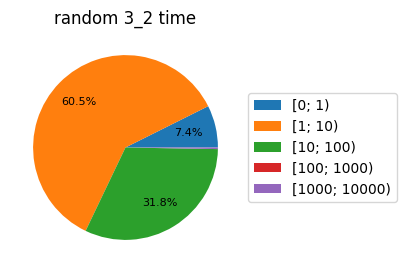

10.366708278656006


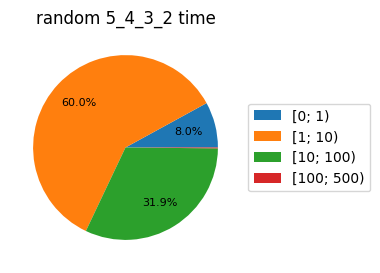

9.476877212524414


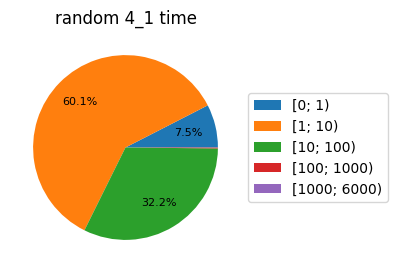

['dagA0.time', 'dagA11.time', 'dagA12.time', 'dagA14.time', 'dagA15.time', 'dagA17.time', 'dagA19.time', 'dagA2.time', 'dagA20.time', 'dagA21.time', 'dagA22.time', 'dagA24.time', 'dagA26.time', 'dagA29.time', 'dagA3.time', 'dagA31.time', 'dagA34.time', 'dagA38.time', 'dagA39.time', 'dagA5.time', 'dagA6.time', 'dagA7.time', 'dagA9.time', 'dagB0.time', 'dagB10.time', 'dagB11.time', 'dagB14.time', 'dagB15.time', 'dagB17.time', 'dagB18.time', 'dagB19.time', 'dagB2.time', 'dagB28.time', 'dagB29.time', 'dagB3.time', 'dagB31.time', 'dagB35.time', 'dagB38.time', 'dagB39.time', 'dagB4.time', 'dagB6.time', 'dagB8.time', 'dagB9.time', 'dagC11.time', 'dagC12.time', 'dagC14.time', 'dagC18.time', 'dagC19.time', 'dagC2.time', 'dagC22.time', 'dagC23.time', 'dagC24.time', 'dagC25.time', 'dagC29.time', 'dagC3.time', 'dagC31.time', 'dagC32.time', 'dagC33.time', 'dagC35.time', 'dagC37.time', 'dagC38.time', 'dagC7.time', 'dagC9.time', 'dagD0.time', 'dagD10.time', 'dagD13.time', 'dagD16.time', 'dagD19.time'

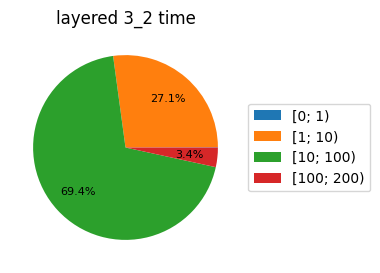

98.07826280593872


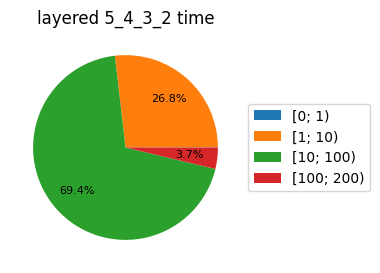

109.0221939086914


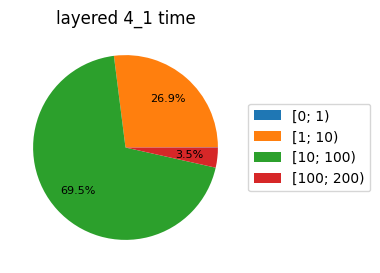

['triadag10_0.time', 'triadag10_1.time', 'triadag10_2.time', 'triadag10_3.time', 'triadag10_4.time', 'triadag10_5.time', 'triadag10_6.time', 'triadag10_7.time', 'triadag10_8.time', 'triadag10_9.time', 'triadag15_0.time', 'triadag15_1.time', 'triadag15_2.time', 'triadag15_3.time', 'triadag15_4.time', 'triadag15_5.time', 'triadag15_6.time', 'triadag15_7.time', 'triadag15_8.time', 'triadag15_9.time', 'triadag20_0.time', 'triadag20_1.time', 'triadag20_2.time', 'triadag20_3.time', 'triadag20_4.time', 'triadag20_5.time', 'triadag20_6.time', 'triadag20_7.time', 'triadag20_8.time', 'triadag20_9.time', 'triadag25_0.time', 'triadag25_1.time', 'triadag25_2.time', 'triadag25_3.time', 'triadag25_4.time', 'triadag25_5.time', 'triadag25_6.time', 'triadag25_7.time', 'triadag25_8.time', 'triadag25_9.time', 'triadag30_0.time', 'triadag30_1.time', 'triadag30_2.time', 'triadag30_3.time', 'triadag30_4.time', 'triadag30_5.time', 'triadag30_6.time', 'triadag30_7.time', 'triadag30_8.time', 'triadag30_9.time',

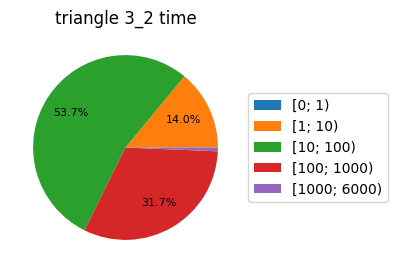

594.5350785255432


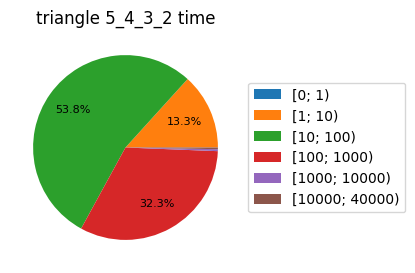

549.7572522163391


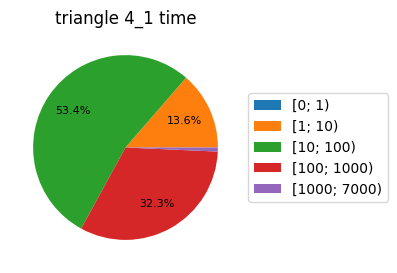

In [ ]:
def roundup(x, n):
    n -= 2
    return int(ceil(x / 10**n)) * 10**n


for graphs_path, graph_type in graph_paths:
    graph_names = sorted(greed_mk_time[graph_type].keys())
    print(graph_names)
    for proc_class in proc_classes:
        fractions: list = []
        for graph_name in graph_names:
            for proc in filter(lambda x: x.startswith(proc_class), greed_mk_time[graph_type][graph_name].keys()):
                # for cr in filter(lambda x: x <= 0.6, greed_mk_time[graph_type][graph_name][proc].keys()):
                for cr in greed_mk_time[graph_type][graph_name][proc].keys():
                    val = greed_mk_time[graph_type][graph_name][proc][cr]
                    fractions.append(val)

        vals = [0 for _ in range(6)]        
        for i in fractions:
            if i < 1:
                ind = 0
            elif i < 10:
                ind = 1
            elif i < 100:
                ind = 2
            elif i < 1000:
                ind = 3
            elif i < 10000:
                ind = 4
            else:
                ind = 5
 
            vals[ind] += 1

        while vals[-1] == 0:
            vals.pop()
        vals = np.array(vals)
        print(vals)
        
        mylabels = ['[0; 1)', '[1; 10)', f'[10; {min(100, roundup(max(fractions), len(vals)))})', f'[100; {min(1000, roundup(max(fractions), len(vals)))})', f'[1000; {min(10000, roundup(max(fractions), len(vals)))})', f'[10000; {roundup(max(fractions), len(vals))})']
        mylabels = mylabels[:len(vals)]

        data = np.array(vals)
        title = graph_type if graph_type != 'sausages' else 'layered'
        
        fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
        ax.set_title(f'{title} {proc_class}')        

        wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data), pctdistance=0.7,
                                  textprops=dict(color="black"))
        ax.legend(wedges, mylabels,
                # title="Ingredients",
                loc="center left",
                bbox_to_anchor=(1, 0, 0.5, 1))

        plt.setp(autotexts, size=8)

        ax.set_title(f'{title} {proc_class} time')

        Path(f'./pics/{title}/pics_total/').mkdir(parents=True, exist_ok=True)
        plt.savefig(f'./pics/{title}/pics_total/{title}_{proc_class}_time.png')
        plt.show()
        plt.close()

In [80]:
def plot_heatmap(data, col_labels, row_labels, title, valfmt: str ="{x:3.1f}", threshold: float|None=None, abs_threshold: bool=False):
    fig, ax = plt.subplots(figsize=(len(col_labels)//2, len(row_labels) + 3))
    im = ax.imshow(data)
    
    ax.set_xticks(range(data.shape[1]), labels=col_labels,
            rotation=-30, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(data.shape[0]), labels=row_labels)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
    
    if threshold is None:
        threshold = im.norm(data.max())/2.
    
    kw = dict(
        horizontalalignment="center",
        verticalalignment="center",
    )
    textcolors=("white", "black")
    
    valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)
    
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if abs_threshold:
                kw.update(color=textcolors[int(data[i, j] > threshold)])
            else:
                kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    ax.set_title(title)

    fig.tight_layout()
    
    return fig, ax, texts

In [87]:
for graphs_path, graph_type in graph_paths:
    files = sorted(list(filter(lambda x: x.endswith('.txt'), listdir(graphs_path.format(graph_type=graph_type).removesuffix('/{graph_name}')))))
    
    for graph_name in files:
        # if 'dag24' not in graph_name:
        #     continue
        
        if 'triadag35' in graph_name or 'triadag4' in graph_name or 'triadag5' in graph_name or 'triadag6' in graph_name:
            continue
        
        pg_names0 = list(greed_mk_data[graph_type][graph_name].keys())
        pgs = list(set(pg.split('x')[0] for pg in pg_names0))
        print(graph_name)
        for pg in pgs:
            pg_names = list(filter(lambda x: x.startswith(pg) , pg_names0))
            cr_list = sorted(list(greed_mk_data[graph_type][graph_name][pg_names[0]].keys()))
            
            pg_names = list(sorted( pg_names, key=lambda x: int(x.split('x')[1]), reverse=True, ))

            heats = [[] for _ in pg_names]
            simple = [[] for _ in pg_names]
            
            for i, pg_name in enumerate(pg_names):
                for cr in cr_list:
                    heats[i].append(
                        greed_mk_data[graph_type][graph_name][pg_name][cr] / greed_data[graph_type][graph_name][pg_name][cr]
                    )   

                    simple[i].append(
                        greed_mk_data[graph_type][graph_name][pg_name][cr] / simple_data[graph_type][graph_name][pg_name][cr]
                    )
            
            heats = np.array(heats)
            simple = np.array(simple)
            
            title = f'{graph_name}\n\n' + f'F(ПЖ_МК{"_CR+" if "geq_cr" in path_greed_mk else ""})/F(Greedy_Reg)'
            title = title.replace("sausages", "layered")
            
            fig, ax, texts = plot_heatmap(heats, cr_list, pg_names, title, valfmt="{x:.2f}", threshold=0.7, abs_threshold=True)
            
            # Loop over data dimensions and create text annotations.
            for i in range(len(pg_names)):
                for j in range(len(cr_list)):
                    if heats[i, j] <= 0.001:
                        val = f'[{simple[i, j]:.2f}]'
                        texts[i*len(cr_list) + j].set(text=f'{val}', ha="center", va="center", color="w")

            Path(f'./pics/{graph_type}/result/{graph_name.removesuffix(".txt")}').mkdir(parents=True, exist_ok=True)
            fig.savefig(f'./pics/{graph_type}/result/{graph_name.removesuffix(".txt")}/{graph_name.removesuffix(".txt")}_{pg}.png')
            # plt.show()
            plt.close(fig)

dag0.txt
dag1.txt
dag10.txt
dag11.txt
dag12.txt
dag13.txt
dag14.txt
dag15.txt
dag16.txt
dag17.txt
dag18.txt
dag19.txt
dag2.txt
dag20.txt
dag21.txt
dag22.txt
dag23.txt
dag24.txt
dag25.txt
dag26.txt
dag27.txt
dag28.txt
dag29.txt
dag3.txt
dag30.txt
dag31.txt
dag32.txt
dag33.txt
dag34.txt
dag35.txt
dag36.txt
dag37.txt
dag38.txt
dag39.txt
dag4.txt
dag40.txt
dag41.txt
dag42.txt
dag43.txt
dag44.txt
dag45.txt
dag46.txt
dag47.txt
dag48.txt
dag49.txt
dag5.txt
dag50.txt
dag51.txt
dag52.txt
dag53.txt
dag54.txt
dag55.txt
dag56.txt
dag57.txt
dag58.txt
dag59.txt
dag6.txt
dag60.txt
dag61.txt
dag62.txt
dag63.txt
dag64.txt
dag65.txt
dag66.txt
dag67.txt
dag68.txt
dag69.txt
dag7.txt
dag70.txt
dag71.txt
dag72.txt
dag73.txt
dag74.txt
dag75.txt
dag76.txt
dag77.txt
dag78.txt
dag79.txt
dag8.txt
dag80.txt
dag81.txt
dag82.txt
dag83.txt
dag84.txt
dag85.txt
dag86.txt
dag87.txt
dag88.txt
dag89.txt
dag9.txt
dag90.txt
dag91.txt
dag92.txt
dag93.txt
dag94.txt
dag95.txt
dag96.txt
dag97.txt
dag98.txt
dag99.txt


In [89]:
for graphs_path, graph_type in graph_paths:
    files = greed_mk_time[graph_type].keys()
    for graph_name in files:
        graph_name = graph_name.replace('.txt', '.time')
        print(graph_name)
        
        pg_names0 = list(greed_mk_time[graph_type][graph_name].keys())
        pgs = list(set(pg.split('x')[0] for pg in pg_names0))
        for pg in pgs:
            pg_names = list(filter(lambda x: x.startswith(pg) , pg_names0))
            cr_list = sorted(list(greed_mk_time[graph_type][graph_name][pg_names[0]].keys()))
            
            pg_names = list(sorted( pg_names, key=lambda x: int(x.split('x')[1]), reverse=True, ))

            heats = [[] for _ in pg_names]
            
            for i, pg_name in enumerate(pg_names):
                for cr in cr_list:
                    heats[i].append(
                        greed_mk_time[graph_type][graph_name][pg_name][cr]
                    )   
            
            heats = np.array(heats) 
            
            alg_class = "Кластерный алгоритм"
            title = f'{graph_name}\n{alg_class}\nВремя выполнения (с)'
            title = title.replace("sausages", "layered")
            
            fig, ax, texts = plot_heatmap(heats, cr_list, pg_names, title, threshold=0.7)
            
            Path(f'./pics/{graph_type}/time//{graph_name.removesuffix(".txt")}').mkdir(parents=True, exist_ok=True)
            fig.savefig(f'./pics/{graph_type}/time//{graph_name.removesuffix(".txt")}/{graph_name.removesuffix(".txt")}_{pg}.png', bbox_inches='tight')
            # plt.show()
            plt.close(fig)

dag41.time
dag71.time
dag15.time
dag8.time
dag95.time
dag99.time
dag74.time
dag31.time
dag4.time
dag90.time
dag46.time
dag17.time
dag16.time
dag94.time
dag7.time
dag44.time
dag85.time
dag30.time
dag52.time
dag36.time
dag68.time
dag84.time
dag25.time
dag23.time
dag0.time
dag11.time
dag48.time
dag45.time
dag97.time
dag18.time
dag65.time
dag88.time
dag77.time
dag22.time
dag47.time
dag37.time
dag63.time
dag56.time
dag78.time
dag89.time
dag32.time
dag43.time
dag82.time
dag62.time
dag26.time
dag58.time
dag6.time
dag33.time
dag49.time
dag10.time
dag40.time
dag5.time
dag79.time
dag24.time
dag28.time
dag34.time
dag60.time
dag1.time
dag81.time
dag13.time
dag64.time
dag54.time
dag93.time
dag61.time
dag98.time
dag19.time
dag51.time
dag75.time
dag91.time
dag59.time
dag21.time
dag53.time
dag73.time
dag39.time
dag66.time
dag96.time
dag72.time
dag9.time
dag67.time
dag42.time
dag20.time
dag29.time
dag86.time
dag55.time
dag69.time
dag92.time
dag80.time
dag83.time
dag70.time
dag50.time
dag57.time
dag27.t

In [31]:
print(1)

1


In [41]:
for graphs_path, graph_type in graph_paths:
    n_min, n_max = 10**10, 0
    e_min, e_max = 10**10, 0
    rho_min, rho_max = 10**10, 0
    rho_s = []
    graph_cnt = 0
    
    for graph_name in listdir(graphs_path):
        if graph_type == 'triangle_new' and (graph_name.startswith('triadag35') or graph_name.startswith('triadag4') or graph_name.startswith('triadag5') or graph_name.startswith('triadag6')):
            continue
        
        g = input_graph(graphs_path + graph_name)
        graph_cnt += 1
        n_min, n_max = min(n_min, len(g.nodes)), max(n_max, len(g.nodes))
        e_min, e_max = min(e_min, len(g.edges)), max(e_max, len(g.edges))
        rho = len(g.edges) / (len(g.nodes))
        rho_min, rho_max = min(rho_min, rho), max(rho_max, rho)
        rho_s.append(rho)
        
    graph_type = graph_type.replace("triangle_new", "triangle_up_to_30")
    print(graph_type)
    print(f'Количество графов: {graph_cnt}')
    print(f'N_min = {n_min}, N_max = {n_max}')
    print(f'E_min = {e_min}, E_max = {e_max}')
    print(f'ρ_min = {rho_min:.2f}, ρ_max = {rho_max:.2f}')
    print(f'ρ_среднее = {np.mean(rho_s):.2f}')
    print()

rand_first100
Количество графов: 100
N_min = 30, N_max = 98
E_min = 41, E_max = 144
ρ_min = 1.35, ρ_max = 1.56
ρ_среднее = 1.48

triangle_up_to_30
Количество графов: 50
N_min = 55, N_max = 465
E_min = 90, E_max = 870
ρ_min = 1.64, ρ_max = 1.87
ρ_среднее = 1.78

layered_all
Количество графов: 361
N_min = 50, N_max = 200
E_min = 141, E_max = 610
ρ_min = 2.64, ρ_max = 3.20
ρ_среднее = 2.99

